# Regression with PyTorch

## Data generation
The **exact** function is $$ f(x) = tanh \big( a \, x^5 + b \, cos(\omega x) \big)$$

but we add a gaussian white noise, so we get $y = f(x) + \epsilon$ with $\epsilon \sim \mathcal{N}(0,\sigma^2)$

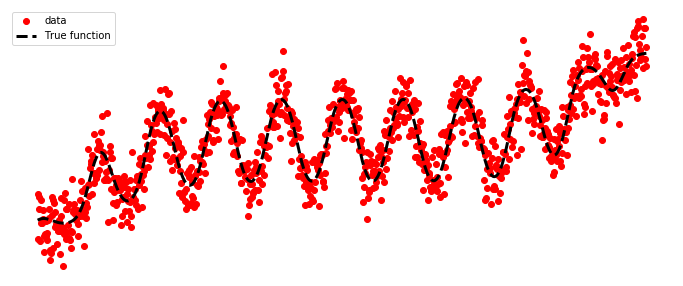

In [348]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

h = 0.002
var = 0.2
omega = 10*math.pi
eps = 0.5
x = torch.arange(-1,1,h).view((-1,1))
y_true = (2*torch.pow(x,5)+eps*torch.cos(omega*x)).view((-1,1))
y_true = torch.tanh(y_true)
y = y_true + var*torch.randn(x.size())
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x,y,'ro', label ='data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.legend()

The black curve represent the exact funtion $f$, and the red points stand for the data $(x, y)$

## Data spliting
We split the data such that $70\%$ will be devoted to the training process, and $30\%$ for the validation

In [358]:
from sklearn.model_selection import train_test_split

ratio = 0.3

x_train, x_test, y_train, y_test  = train_test_split(x.numpy(), y.numpy(), test_size=ratio)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

n = x_train.shape[0]

print('Training set size :', n)

Training set size : 700


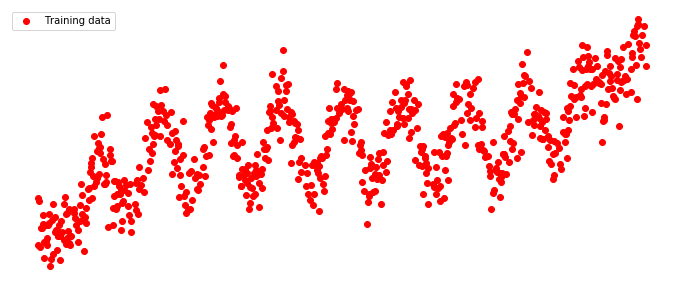

In [359]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label ='Training data')
plt.legend()

## Linear regression

We first try to learn the function $f$ by using a linear regression.

In [360]:
from torch import nn

class LinearNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

As the size of the training set is small, we use a quasi-Newton optimization method.

In [376]:
from torch import optim

input_dim = x.shape[1]
output_dim = y.shape[1]

lr = 1e-1
epochs = 10

model = LinearNeuralNetwork(input_dim, output_dim)
loss_func = nn.MSELoss(reduction='mean')
opt = optim.LBFGS(model.parameters(), lr=lr)

In [378]:
for epoch in range(epochs):
    def closure():
        opt.zero_grad()
        y_pred = model(x_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        return loss
    opt.step(closure)
    print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.08671067655086517
epoch 1 / loss = 0.08671067655086517
epoch 2 / loss = 0.08671067655086517
epoch 3 / loss = 0.08671067655086517
epoch 4 / loss = 0.08671067655086517
epoch 5 / loss = 0.08671067655086517
epoch 6 / loss = 0.08671067655086517
epoch 7 / loss = 0.08671067655086517
epoch 8 / loss = 0.08671067655086517
epoch 9 / loss = 0.08671067655086517


In [379]:
train_loss = loss_func(model(x_train), y_train).item()
val_loss = loss_func(model(x_test), y_test).item()
true_loss = loss_func(model(x), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)

df = pd.DataFrame(index=['Training_Loss','Validation_Loss','True_Loss'])
df['LinearRegression'] = [train_loss, val_loss, true_loss]

Training set loss = 0.15862992405891418
Test set loss = 0.1529393345117569
True loss = 0.12335855513811111


In [380]:
y_pred = model(x).detach().numpy()

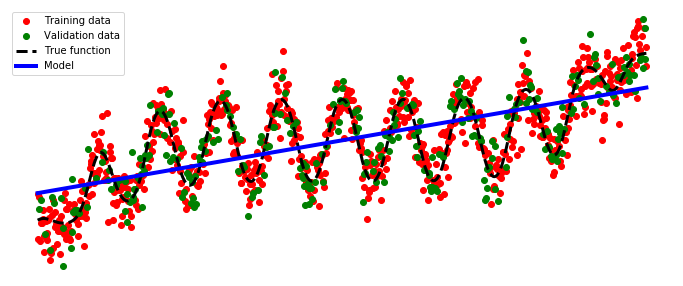

In [381]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The red points stand for the training data, whereas the green points stand for the validation data.
The function learnt by using the linear regression is depicted in blue.

As we can see, we have a high bias.
The model is not enough complex.

## Polynomial regression

A way to adapt our linear regression to more complex functions, is by extended the input features.
Here we try to learn the function $f$ by using the following model: $$\hat{y} = \alpha_0 + \sum_{d=1}^D \alpha_d \, x^d$$
and where the coefficients $\alpha_d$ will be learnt.

In [382]:
D = 200

x_train_new = torch.empty((n,D))
x_test_new = torch.empty((x_test.shape[0],D))
x_new = torch.empty((x.shape[0],D))

for d in range(D):
    x_train_new[:,d] = torch.pow(x_train.view(-1),d+1)
    x_test_new[:,d] = torch.pow(x_test.view(-1),d+1)
    x_new[:,d] = torch.pow(x.view(-1),d+1)

In [383]:
lr = 1e-1
epochs = 10

model_poly = LinearNeuralNetwork(D, output_dim)
loss_func = nn.MSELoss(reduction='mean')
opt = optim.LBFGS(model_poly.parameters(), lr=lr)

In [384]:
for epoch in range(epochs):
    def closure():
        opt.zero_grad()
        output = model_poly(x_train_new)
        loss = loss_func(output, y_train)
        loss.backward()
        return loss
    opt.step(closure)
    print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.08671067655086517
epoch 1 / loss = 0.08671067655086517
epoch 2 / loss = 0.08671067655086517
epoch 3 / loss = 0.08671067655086517
epoch 4 / loss = 0.08671067655086517
epoch 5 / loss = 0.08671067655086517
epoch 6 / loss = 0.08671067655086517
epoch 7 / loss = 0.08671067655086517
epoch 8 / loss = 0.08671067655086517
epoch 9 / loss = 0.08671067655086517


In [385]:
train_loss = loss_func(model_poly(x_train_new), y_train).item()
val_loss = loss_func(model_poly(x_test_new), y_test).item()
true_loss = loss_func(model_poly(x_new), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)

df['PolynomialRegression'] = [train_loss, val_loss, true_loss]

Training set loss = 0.11724294722080231
Test set loss = 0.12925395369529724
True loss = 0.08679293841123581


In [386]:
y_pred = model_poly(x_new).detach().numpy()

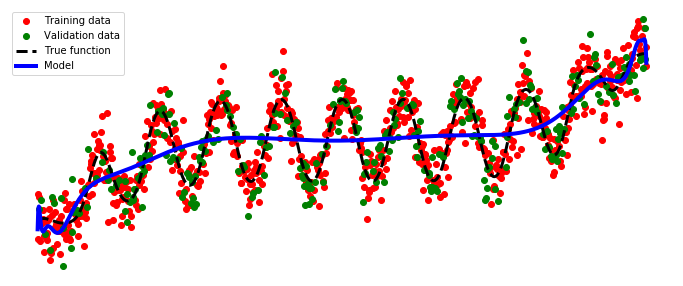

In [387]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

Even if the result is better, we still have a high bias.

To handle this issue, we will use a deep neural network.

## Deep Neural Network
Consider now a deep neural network compose of three hidden layers.

In [388]:
class DeepNeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim):
        super().__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_1_dim)   # hidden layer
        self.hidden_2 = torch.nn.Linear(hidden_1_dim, hidden_2_dim)   # hidden layer
        self.hidden_3 = torch.nn.Linear(hidden_2_dim, hidden_3_dim)   # hidden layer
        self.predict = torch.nn.Linear(hidden_3_dim, output_dim)   # output layer

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        return self.predict(x)
    

Since this time, the model is costly to evaluate, we choose the Adam optimization method.
Futhermore, in order to prevent overfittig, we use $L^2$-regularization.

In [443]:
input_dim = x.shape[1]
hidden_1_dim = 100
hidden_2_dim = 100
hidden_3_dim = 100
output_dim = y.shape[1]

lr = 1e-2
epochs = 10000

model_2 = DeepNeuralNetwork(input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim)
loss_func = nn.MSELoss(reduction='mean')
opt = optim.Adam(model_2.parameters(), lr=lr, weight_decay = 1e-6, amsgrad = True)

In [444]:
loss_train = []
loss_test = []
for epoch in range(epochs):
    def closure():
        opt.zero_grad()
        output = model_2(x_train)
        loss = loss_func(output, y_train)
        loss.backward()
        return loss
    loss = opt.step(closure)
    loss_train.append(loss_func(model_2(x_train), y_train).item())
    loss_test.append(loss_func(model_2(x_test), y_test).item())
    if epoch%1000 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.28137195110321045
epoch 1000 / loss = 0.05352228879928589
epoch 2000 / loss = 0.03746303543448448
epoch 3000 / loss = 0.036986708641052246
epoch 4000 / loss = 0.03582051023840904
epoch 5000 / loss = 0.035544995218515396
epoch 6000 / loss = 0.03559492155909538
epoch 7000 / loss = 0.03546328842639923
epoch 8000 / loss = 0.03552352264523506
epoch 9000 / loss = 0.03530547767877579


In [446]:
train_loss = loss_func(model_2(x_train), y_train).item()
val_loss = loss_func(model_2(x_test), y_test).item()
true_loss = loss_func(model_2(x), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['DeepNeuralNetwork'] = [train_loss, val_loss, true_loss]

Training set loss = 0.03544154390692711
Test set loss = 0.04654742777347565
True loss = 0.004891285672783852


In [447]:
y_pred = model_2(x).detach().numpy()

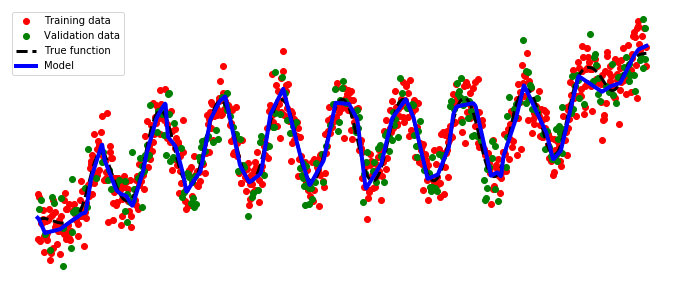

In [448]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The deep neural network is able to learn the complexity provided by the fuction $f$.

Moreover, there is no overfitting.
It is shown on the graphic above, where the loss during epoch evolution in depicted for the training set (in black), and for the validation set (in red).
We can see that the two loss are decreasing.

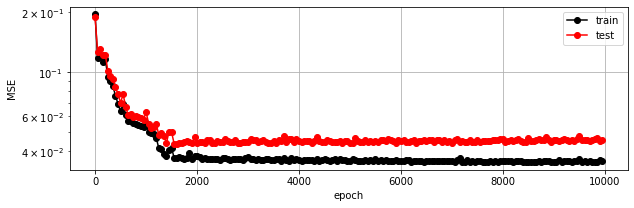

In [450]:
plt.figure(figsize=(10,3))
plt.plot(range(epochs)[::50], loss_train[::50],'ko-', label = 'train')
plt.plot(range(epochs)[::50], loss_test[::50],'ro-', label = 'test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='best')

Let us now compare the performance of the deep neural network with support machine vectors, which are powerfull 
ML algorihtms.

## SVM with rbf kernel
We first consider the classical radial basis function kernel.
Hence, we assume that the function $f$ is smooth ($f \in \mathcal{C}^{\infty}$).

In [451]:
from sklearn.svm import SVR

clf = SVR(C=1.0, kernel='rbf')
clf.fit(x_train, y_train.reshape(-1,))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [452]:
train_loss = loss_func(torch.from_numpy(clf.predict(x_train)).view(-1,1), y_train).item()
val_loss = loss_func(torch.from_numpy(clf.predict(x_test)).view(-1,1), y_test).item()
true_loss = loss_func(torch.from_numpy(clf.predict(x)).view(-1,1), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['SVM_rbf'] = [train_loss, val_loss, true_loss]

Training set loss = 0.12040788443547705
Test set loss = 0.13024778942939763
True loss = 0.08918800962714572


In [453]:
y_pred = clf.predict(x)

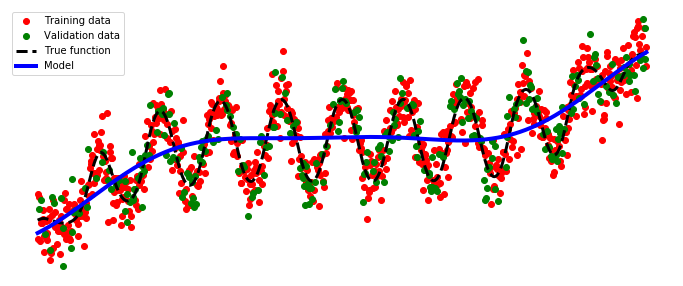

In [454]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

The assumption on the smoothness of f was incorrect, and the model learnt is not well-fitting to the data.

We then choose an other kernel.

## SVM with Matérn kernel (less smooth approximation)

Matérn kernel are a generalization of rbf kernel, but where a parameter $\nu$ allow to choose the good smoothness

In [455]:
from sklearn.gaussian_process.kernels import Matern

kernel = Matern(nu=0.35)

clf = SVR(C=1.0, kernel=kernel)
clf.fit(x_train, y_train.reshape(-1,))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel=Matern(length_scale=1, nu=0.35), max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [456]:
train_loss = loss_func(torch.from_numpy(clf.predict(x_train)).view(-1,1), y_train).item()
val_loss = loss_func(torch.from_numpy(clf.predict(x_test)).view(-1,1), y_test).item()
true_loss = loss_func(torch.from_numpy(clf.predict(x)).view(-1,1), y_true).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
print('True loss =', true_loss)
df['SVM_matern'] = [train_loss, val_loss, true_loss]

Training set loss = 0.03433448448525653
Test set loss = 0.04428085183964867
True loss = 0.005765686921998945


In [457]:
y_pred = clf.predict(x)

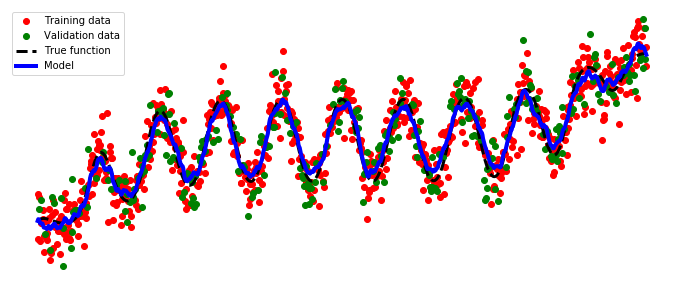

In [458]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro', label='Training data')
plt.plot(x_test,y_test,'go', label='Validation data')
plt.plot(x,y_true,'k--',linewidth='3', label='True function')
plt.plot(x,y_pred,'b-',linewidth='4', label='Model')
plt.legend()

## Summary
The above graphic show the accuracy onto the different sets (training, validation, and true function without 
disturbing).

We can see that the Deep Neural Network and the SVM-Matérn best perform.

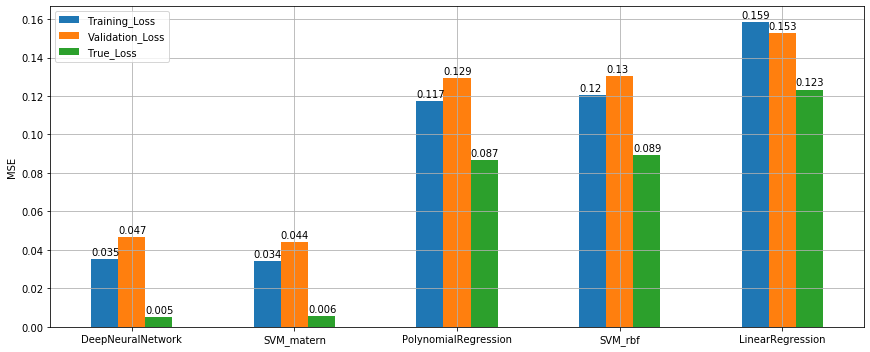

In [459]:
ax = df.T.sort_values(by='True_Loss',ascending=True).plot(kind='bar',figsize=(12,5),rot=0)
for p in ax.patches:
    ax.annotate(round(p.get_height(),3), (p.get_x(), p.get_height()+0.002))
plt.tight_layout()
plt.ylabel('MSE')
plt.grid()

In [460]:
df.T.sort_values(by='True_Loss',ascending=True)

,Training_Loss,Validation_Loss,True_Loss
DeepNeuralNetwork,0.035442,0.046547,0.004891
SVM_matern,0.034334,0.044281,0.005766
PolynomialRegression,0.117243,0.129254,0.086793
SVM_rbf,0.120408,0.130248,0.089188
LinearRegression,0.158630,0.152939,0.123359


# Conclusion

Deep Neural Networks allow to learn complex function with the accuracy of best-fitted ML algorithms and
without the need of hand-engeneering.